# Well Deliverability (System Analysis)
**Objective:** Determine the production rate of a complete well system (Reservoir $\to$ Separator) using Nodal Analysis.

**Author:** Ade Anggi Naluriawan Santoso

In previous chapters, we looked at components in isolation:
* **IPR:** What the reservoir can give.
* **TPR:** What the tubing costs in pressure.
* **Choke:** How the wellhead restriction affects flow.

**The Nodal Analysis Concept:**
We select a specific point in the system (the "Node"). For this exercise, we will use the **Bottomhole** as the solution node.

At the solution node, the pressure determined from the **Inflow** (Reservoir) must equal the pressure determined from the **Outflow** (Surface + Tubing).

$$P_{wf\_supply} = P_{wf\_demand}$$

Where:
1.  **Supply (IPR):** $P_{res} - \Delta P_{reservoir}$
2.  **Demand (Outflow):** $P_{separator} + \Delta P_{flowline} + \Delta P_{choke} + \Delta P_{tubing}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Defining the Component Models
We need to bring back our functions from previous chapters to build the full chain.

**The Outflow Logic (Bottom-Up Calculation):**
To find the *Required Bottomhole Pressure* ($P_{wf\_demand}$) for a specific rate ($q$):
1.  Start at the **Separator Pressure** ($P_{sep}$).
2.  Add **Flowline Friction** ($\Delta P_{line}$) $\rightarrow$ Gets Downstream Choke Pressure.
3.  Add **Choke Pressure Drop** ($\Delta P_{choke}$) $\rightarrow$ Gets Wellhead Pressure ($P_{wh}$).
4.  Add **Tubing Pressure Drop** ($\Delta P_{tubing}$) $\rightarrow$ Gets Bottomhole Pressure ($P_{wf}$).

In [2]:
# --- 1. RESERVOIR (INFLOW) ---
def get_ipr_pressure(q, p_res, q_max):
    """Calculates Pwf from Rate using Vogel's IPR."""
    if q >= q_max: return 0.0
    if q <= 0: return p_res
    
    # Quadratic solution for Vogel
    # q/q_max = 1 - 0.2(P/Pr) - 0.8(P/Pr)^2
    y = q / q_max
    p_ratio = (-0.2 + np.sqrt(0.2**2 - 4 * 0.8 * (y - 1))) / (2 * 0.8)
    return p_ratio * p_res

# --- 2. SURFACE & CHOKE ---
def get_wellhead_pressure_req(q, p_sep, choke_size_64, glr):
    """
    Calculates required Wellhead Pressure (Pwh) to deliver rate q 
    through the choke against Separator Pressure.
    """
    # A. Flowline Loss (Simplified)
    # Assume short flowline, minor friction proportional to q^2
    dp_line = 0.00001 * (q ** 2)
    p_downstream = p_sep + dp_line
    
    # B. Choke Model (Gilbert)
    # We rearrange Gilbert to find P_wh required for a given rate q and Size S
    # P_wh = (435 * R^0.546 * q) / S^1.89
    
    # Note: Gilbert assumes Critical Flow. 
    # If P_downstream > P_critical, this correlation technically breaks, 
    # but for this exercise we assume we need enough P_wh to drive the rate.
    
    R_mcf = glr / 1000.0
    S = choke_size_64
    
    p_wh_choke = (435 * (R_mcf ** 0.546) * q) / (S ** 1.89)
    
    # The required P_wh is the maximum of:
    # 1. Pressure to overcome choke restriction (Critical Flow)
    # 2. Pressure to overcome downstream backpressure (Subcritical limit)
    # For simplicity in this solver, we use the Gilbert result 
    # but ensure it's at least higher than P_downstream.
    
    return max(p_wh_choke, p_downstream + 10)

# --- 3. TUBING (OUTFLOW) ---
def get_bottomhole_pressure_req(q, p_wh, depth, glr):
    """
    Calculates Required Pwf given Pwh (Tubing Intake).
    """
    # Simplified Gradient Model (similar to Ch 4)
    # Hydrostatic decreases as GLR increases (gas lift effect)
    grad_elev = 0.35 * np.exp(-0.0001 * glr) 
    p_hydro = depth * grad_elev
    
    # Friction increases with rate squared
    p_friction = 1.5e-5 * (q ** 2) * (depth/1000)
    
    return p_wh + p_hydro + p_friction

## 2. The System Solver
Now we define the **Node**. We will solve for the rate $q$ where Supply meets Demand.

$$Residual(q) = P_{IPR}(q) - P_{Total\_Outflow}(q)$$

We will solve this for a specific **Choke Size**. This allows us to answer: *"How much will my well produce if I set the choke to 32/64?"*

In [3]:
def solve_system(p_res, q_max, p_sep, depth, choke_size, glr):
    """
    Finds the operating rate for the full system.
    """
    
    def residual(q):
        if q <= 0.1: q = 0.1 # Avoid zero division/errors
        
        # 1. Supply (Reservoir)
        p_supply = get_ipr_pressure(q, p_res, q_max)
        
        # 2. Demand (Surface + Tubing)
        # a. Get P_wh required to cross choke
        p_wh_req = get_wellhead_pressure_req(q, p_sep, choke_size, glr)
        
        # b. Get P_wf required to lift fluid to that P_wh
        p_demand = get_bottomhole_pressure_req(q, p_wh_req, depth, glr)
        
        return p_supply - p_demand

    # Find root
    try:
        # Check Dead Well (Demand > Supply at q~0)
        # Note: At q=0, P_demand is just P_sep + Hydrostatic. 
        # If P_res < P_sep + Hydrostatic, well won't flow naturally.
        if residual(0.1) < 0:
            return 0.0, 0.0, "Dead Well"
            
        q_sol = brentq(residual, 0.1, q_max)
        p_sol = get_ipr_pressure(q_sol, p_res, q_max)
        return q_sol, p_sol, "Flowing"
    except:
        return 0.0, 0.0, "No Solution"

# --- TEST CASE ---
# Field Data
data = {
    'p_res': 3000,   # psia
    'q_max': 5000,   # stb/d
    'p_sep': 100,    # Separator Pressure (psia)
    'depth': 8000,   # ft
    'glr': 500,      # scf/stb
    'choke_size': 32 # /64ths
}

q_op, p_op, status = solve_system(**data)

print(f"System Status: {status}")
print(f"Production Rate: {q_op:.2f} stb/d")
print(f"Flowing BHP:     {p_op:.2f} psia")

System Status: Flowing
Production Rate: 412.50 stb/d
Flowing BHP:     2859.58 psia


## 3. Deliverability Sensitivity (Choke Settings)
A key part of **Well Deliverability** is determining the optimal choke setting.
* **Small Choke:** Restricts flow, keeps $P_{wh}$ high, maintains reservoir energy.
* **Large Choke:** Increases flow, lowers $P_{wh}$, but may cause sand production or liquid loading.

Let's generate the **Deliverability Plot** for various choke sizes.

Choke      | Rate (stb/d)    | Pwf (psia)     
---------------------------------------------
16         | 173.85          | 2941.55        
24         | 303.58          | 2897.24        
32         | 412.50          | 2859.58        
40         | 494.47          | 2830.94        
48         | 547.23          | 2812.37        
64         | 547.23          | 2812.37        


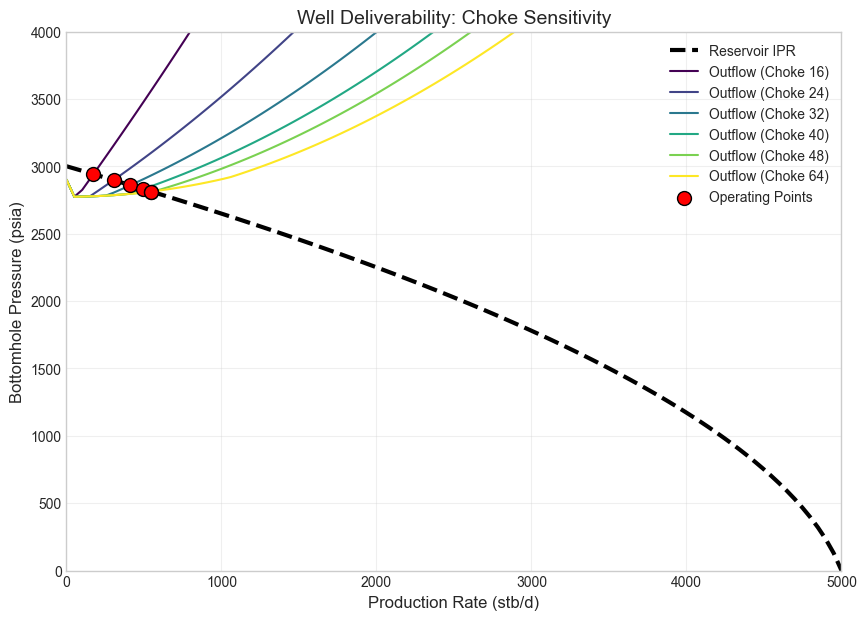

In [4]:
# Choke sizes to analyze
choke_sizes = [16, 24, 32, 40, 48, 64]

# Storage for results
results_q = []
results_p = []

print(f"{'Choke':<10} | {'Rate (stb/d)':<15} | {'Pwf (psia)':<15}")
print("-" * 45)

for sz in choke_sizes:
    q, p, s = solve_system(data['p_res'], data['q_max'], data['p_sep'], 
                           data['depth'], sz, data['glr'])
    results_q.append(q)
    results_p.append(p)
    print(f"{sz:<10} | {q:<15.2f} | {p:<15.2f}")

# --- PLOTTING ---
plt.figure(figsize=(10, 7))

# 1. Plot IPR (Supply) - Fixed Curve
q_space = np.linspace(0, data['q_max'], 100)
p_ipr = [get_ipr_pressure(q, data['p_res'], data['q_max']) for q in q_space]
plt.plot(q_space, p_ipr, color='black', linewidth=3, linestyle='--', label='Reservoir IPR')

# 2. Plot Total Outflow Curves for each Choke
# To visualize this, we calculate the Demand Pressure curve for each choke
for sz, col in zip(choke_sizes, plt.cm.viridis(np.linspace(0, 1, len(choke_sizes)))):
    p_outflow = []
    for q in q_space:
        if q < 1: 
            p_out = data['p_sep'] + (data['depth']*0.35) # Approx static head
        else:
            p_wh = get_wellhead_pressure_req(q, data['p_sep'], sz, data['glr'])
            p_out = get_bottomhole_pressure_req(q, p_wh, data['depth'], data['glr'])
        p_outflow.append(p_out)
    
    plt.plot(q_space, p_outflow, color=col, label=f'Outflow (Choke {sz})')

# 3. Plot Operating Points
plt.scatter(results_q, results_p, color='red', s=100, zorder=10, edgecolor='black', label='Operating Points')

plt.title("Well Deliverability: Choke Sensitivity", fontsize=14)
plt.xlabel("Production Rate (stb/d)", fontsize=12)
plt.ylabel("Bottomhole Pressure (psia)", fontsize=12)
plt.ylim(0, 4000)
plt.xlim(0, data['q_max'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Summary
This chart is the ultimate output of Nodal Analysis.

* **The Black Dashed Line** is the Reservoir's capability.
* **The Colored Lines** are the System's requirements for different choke sizes.
* **The Red Dots** are the actual production rates we can expect.

Notice how the Outflow curves shoot up vertically? That is the **Choke Effect**. As rate increases, the pressure required to push fluid through that tiny hole increases exponentially (Gilbert's $q \propto S^{1.89}$).